In [1]:
import keras
import tensorflow as tf
import gdal
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from keras_unet.models import custom_unet, satellite_unet
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras_unet.utils import plot_segm_history

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
image_dir = Path(r'/media/hkropp/research/milkweed/training/img_g22/img_g22')
milk_dir = Path(r'/media/hkropp/research/milkweed/training/masks_g22')

In [3]:
def make_path(img_dir, prefix, number):
    return os.path.join(img_dir, f"{prefix}_{number}.tif")

In [4]:
def img_number(fpath: str) -> int:
    return int(os.path.splitext(os.path.split(fpath)[1])[0].split('_')[-1])

In [5]:
import typing as t

def load_image_rgb(path: str, shape: t.Tuple[int,int,int], dtype) -> np.ndarray:
    image = np.zeros(shape = shape, dtype=dtype)
    ds= gdal.Open(path, gdal.GA_ReadOnly)
    for i in (1, 2, 3):
        image[:, :, i-1] = ds.GetRasterBand(i).ReadAsArray()
    return image


In [6]:
def load_image(path: str) -> np.ndarray:
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    return ds.GetRasterBand(1).ReadAsArray()

In [7]:
def load_stack_rgb(shape, dtype, img_dir, prefix):
    stack = np.zeros(shape = shape, dtype = dtype)
    for i in range(shape[0]):
        image_path = make_path(img_dir, prefix, i + 1)
        # subsets for rgb bands only
        stack[i, :, :, :] = load_image_rgb(image_path, (shape[1], shape[2], shape[3]), dtype)
    return stack

# need to skip when there is no mask
# loads single band mask
def load_stack_safely(shape, dtype, img_dir, prefix):
    stack = np.zeros(shape = shape, dtype = dtype)
    for i in range(shape[0]):
        image_path = make_path(img_dir, prefix, i + 1)
        if not os.path.isfile(image_path):
            print("skipping", image_path)
            continue
        stack[i, :, :] = load_image(image_path)
    return stack

In [8]:
# training total data size
I = 200
# image dim 1
N = 256
# image dim 2
M = 256
# number of image bands
L = 3
# number of classes
V = 1

In [9]:
train_images = load_stack_rgb((I, N, M, L), np.int8, image_dir, "img")
train_images_R = train_images.reshape(I, N, M, L)

In [10]:
train_images_R.shape

(200, 256, 256, 3)

In [11]:
test = gdal.Open(r'/media/hkropp/research/milkweed/training/img_g22/img_g22/img_1.tif', gdal.GA_ReadOnly)

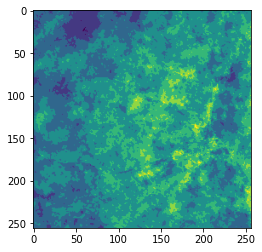

In [12]:
plt.imshow(test.GetRasterBand(3).ReadAsArray())

In [13]:
milk_mask = load_stack_safely((I, N, M), np.int8, milk_dir, "milkweed")

skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_1.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_2.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_3.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_4.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_5.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_6.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_7.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_8.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_9.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_10.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_11.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_12.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_13.tif
skipping /media/hkrop

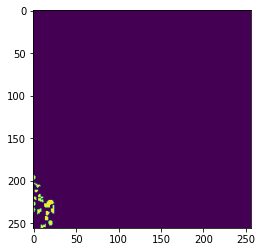

In [14]:
plt.imshow(milk_mask[13, :,:])

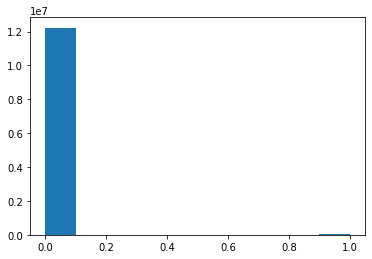

In [15]:
plt.hist(milk_mask[13:,:].flatten())
plt.show()

In [17]:
# alter unet code from package
from keras_unet import TF
if TF:
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import ( 
        BatchNormalization, Conv2D, Conv2DTranspose,
        MaxPooling2D, UpSampling2D, Input,
        concatenate
    )
else:    
    from keras.models import Model
    from keras.layers import ( 
        BatchNormalization, Conv2D, Conv2DTranspose,
        MaxPooling2D, UpSampling2D, Input,
        concatenate
    )


def bn_conv_relu(input, filters, bachnorm_momentum, **conv2d_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2D(filters, **conv2d_args)(x)
    return x

def bn_upconv_relu(input, filters, bachnorm_momentum, **conv2d_trans_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2DTranspose(filters, **conv2d_trans_args)(x)
    return x

def satellite_unet2(
    input_shape,
    num_classes=1,
    output_activation='sigmoid',
    num_layers=4):

    inputs = Input(input_shape)   
    
    filters = 64
    upconv_filters = 96

    kernel_size = (5,5)
    activation = 'relu'
    strides = (1,1)
    padding = 'same'
    kernel_initializer = 'he_normal'

    conv2d_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':strides,
        'padding':padding,
        'kernel_initializer':kernel_initializer
        }

    conv2d_trans_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':(2,2),
        'padding':padding,
        'output_padding':(1,1)
        }

    bachnorm_momentum = 0.01

    pool_size = (2,2)
    pool_strides = (2,2)
    pool_padding = 'valid'

    maxpool2d_args = {
        'pool_size':pool_size,
        'strides':pool_strides,
        'padding':pool_padding,
        }
    
    x = Conv2D(filters, **conv2d_args)(inputs)
    c1 = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)    
    x = bn_conv_relu(c1, filters, bachnorm_momentum, **conv2d_args)
    x = MaxPooling2D(**maxpool2d_args)(x)

    down_layers = []

    for l in range(num_layers):
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        down_layers.append(x)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = MaxPooling2D(**maxpool2d_args)(x)

    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    for conv in reversed(down_layers):        
        x = concatenate([x, conv])  
        x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    x = concatenate([x, c1])
    x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
           
    outputs = Conv2D(num_classes, kernel_size=(1,1), strides=(1,1), activation=output_activation, padding='valid') (x)       
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [18]:
model = satellite_unet2((N, M, 3), V)

In [19]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = "binary_crossentropy",
    metrics = [iou, iou_thresholded],
)

In [20]:
history = model.fit(train_images_R, milk_mask, epochs = 400)

Epoch 1/400
7/7 [==============================] - 60s 7s/step - loss: 0.2325 - iou: 0.0016 - iou_thresholded: 0.0015
Epoch 2/400
7/7 [==============================] - 52s 7s/step - loss: 0.0170 - iou: 0.0015 - iou_thresholded: 0.0063 
Epoch 3/400
7/7 [==============================] - 53s 7s/step - loss: 0.0130 - iou: 0.0095 - iou_thresholded: 7.0575e-04
Epoch 4/400
7/7 [==============================] - 52s 7s/step - loss: 0.0102 - iou: 0.0208 - iou_thresholded: 0.0025
Epoch 5/400
7/7 [==============================] - 52s 7s/step - loss: 0.0099 - iou: 0.0273 - iou_thresholded: 0.0099
Epoch 6/400
7/7 [==============================] - 52s 7s/step - loss: 0.0092 - iou: 0.0345 - iou_thresholded: 0.1672
Epoch 7/400
7/7 [==============================] - 53s 7s/step - loss: 0.0099 - iou: 0.0147 - iou_thresholded: 0.0017
Epoch 8/400
7/7 [==============================] - 52s 7s/step - loss: 0.0086 - iou: 0.0720 - iou_thresholded: 0.0838
Epoch 9/400
7/7 [==============================] - 

7/7 [==============================] - 98s 14s/step - loss: 0.0051 - iou: 0.1819 - iou_thresholded: 0.2148
Epoch 70/400
7/7 [==============================] - 99s 14s/step - loss: 0.0053 - iou: 0.1636 - iou_thresholded: 0.2197
Epoch 71/400
7/7 [==============================] - 100s 14s/step - loss: 0.0062 - iou: 0.1006 - iou_thresholded: 0.1233
Epoch 72/400
7/7 [==============================] - 99s 14s/step - loss: 0.0056 - iou: 0.1092 - iou_thresholded: 0.1141
Epoch 73/400
7/7 [==============================] - 99s 14s/step - loss: 0.0054 - iou: 0.1335 - iou_thresholded: 0.2240
Epoch 74/400
7/7 [==============================] - 99s 14s/step - loss: 0.0064 - iou: 0.1038 - iou_thresholded: 0.0829
Epoch 75/400
7/7 [==============================] - 100s 14s/step - loss: 0.0066 - iou: 0.1497 - iou_thresholded: 0.2154
Epoch 76/400
7/7 [==============================] - 98s 14s/step - loss: 0.0074 - iou: 0.0638 - iou_thresholded: 0.0636
Epoch 77/400
7/7 [==============================] -

7/7 [==============================] - 136s 19s/step - loss: 0.0050 - iou: 0.1035 - iou_thresholded: 0.2583
Epoch 137/400
7/7 [==============================] - 137s 19s/step - loss: 0.0048 - iou: 0.1560 - iou_thresholded: 0.3301
Epoch 138/400
7/7 [==============================] - 138s 19s/step - loss: 0.0050 - iou: 0.1470 - iou_thresholded: 0.2022
Epoch 139/400
7/7 [==============================] - 138s 19s/step - loss: 0.0049 - iou: 0.1805 - iou_thresholded: 0.1794
Epoch 140/400
7/7 [==============================] - 138s 19s/step - loss: 0.0045 - iou: 0.1750 - iou_thresholded: 0.3103
Epoch 141/400
7/7 [==============================] - 137s 19s/step - loss: 0.0048 - iou: 0.1921 - iou_thresholded: 0.2134
Epoch 142/400
7/7 [==============================] - 136s 19s/step - loss: 0.0046 - iou: 0.2040 - iou_thresholded: 0.3046
Epoch 143/400
7/7 [==============================] - 137s 19s/step - loss: 0.0041 - iou: 0.1703 - iou_thresholded: 0.1999
Epoch 144/400
7/7 [===================

7/7 [==============================] - 97s 14s/step - loss: 0.0044 - iou: 0.2058 - iou_thresholded: 0.2558
Epoch 204/400
7/7 [==============================] - 99s 14s/step - loss: 0.0066 - iou: 0.1380 - iou_thresholded: 0.1554
Epoch 205/400
7/7 [==============================] - 99s 14s/step - loss: 0.0054 - iou: 0.1312 - iou_thresholded: 0.1249
Epoch 206/400
7/7 [==============================] - 98s 14s/step - loss: 0.0056 - iou: 0.1772 - iou_thresholded: 0.2645
Epoch 207/400
7/7 [==============================] - 99s 14s/step - loss: 0.0051 - iou: 0.1531 - iou_thresholded: 0.1658
Epoch 208/400
7/7 [==============================] - 99s 14s/step - loss: 0.0061 - iou: 0.0981 - iou_thresholded: 0.1548
Epoch 209/400
7/7 [==============================] - 98s 14s/step - loss: 0.0049 - iou: 0.1337 - iou_thresholded: 0.1742
Epoch 210/400
7/7 [==============================] - 97s 14s/step - loss: 0.0042 - iou: 0.1915 - iou_thresholded: 0.3013
Epoch 211/400
7/7 [===========================

7/7 [==============================] - 52s 7s/step - loss: 0.0052 - iou: 0.1474 - iou_thresholded: 0.1903
Epoch 272/400
7/7 [==============================] - 52s 7s/step - loss: 0.0058 - iou: 0.1035 - iou_thresholded: 0.1239
Epoch 273/400
7/7 [==============================] - 52s 7s/step - loss: 0.0050 - iou: 0.1445 - iou_thresholded: 0.2021
Epoch 274/400
7/7 [==============================] - 52s 7s/step - loss: 0.0047 - iou: 0.1615 - iou_thresholded: 0.1950
Epoch 275/400
7/7 [==============================] - 52s 7s/step - loss: 0.0046 - iou: 0.2012 - iou_thresholded: 0.2407
Epoch 276/400
7/7 [==============================] - 52s 7s/step - loss: 0.0042 - iou: 0.1875 - iou_thresholded: 0.4004
Epoch 277/400
7/7 [==============================] - 52s 7s/step - loss: 0.0047 - iou: 0.1748 - iou_thresholded: 0.1524
Epoch 278/400
7/7 [==============================] - 52s 7s/step - loss: 0.0041 - iou: 0.2191 - iou_thresholded: 0.3303
Epoch 279/400
7/7 [==============================] - 5

7/7 [==============================] - 52s 7s/step - loss: 0.0026 - iou: 0.4520 - iou_thresholded: 0.5831
Epoch 340/400
7/7 [==============================] - 52s 7s/step - loss: 0.0029 - iou: 0.3934 - iou_thresholded: 0.5454
Epoch 341/400
7/7 [==============================] - 51s 7s/step - loss: 0.0050 - iou: 0.2066 - iou_thresholded: 0.2717
Epoch 342/400
7/7 [==============================] - 51s 7s/step - loss: 0.0051 - iou: 0.1846 - iou_thresholded: 0.2931
Epoch 343/400
7/7 [==============================] - 52s 7s/step - loss: 0.0056 - iou: 0.1345 - iou_thresholded: 0.1124
Epoch 344/400
7/7 [==============================] - 52s 7s/step - loss: 0.0049 - iou: 0.2000 - iou_thresholded: 0.2741
Epoch 345/400
7/7 [==============================] - 52s 7s/step - loss: 0.0043 - iou: 0.1723 - iou_thresholded: 0.2487
Epoch 346/400
7/7 [==============================] - 52s 7s/step - loss: 0.0041 - iou: 0.1880 - iou_thresholded: 0.2590
Epoch 347/400
7/7 [==============================] - 5

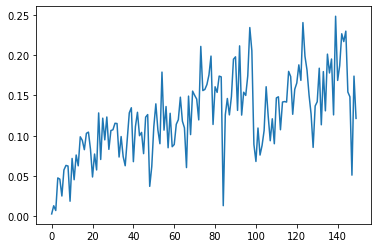

In [23]:
plt.plot(history.history['iou'])

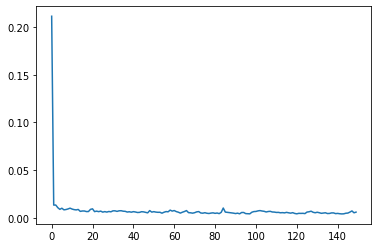

In [24]:
plt.plot(history.history['loss'])

In [25]:
Y_pred = model.predict(train_images_R)

7/7 [==============================] - 20s 3s/step


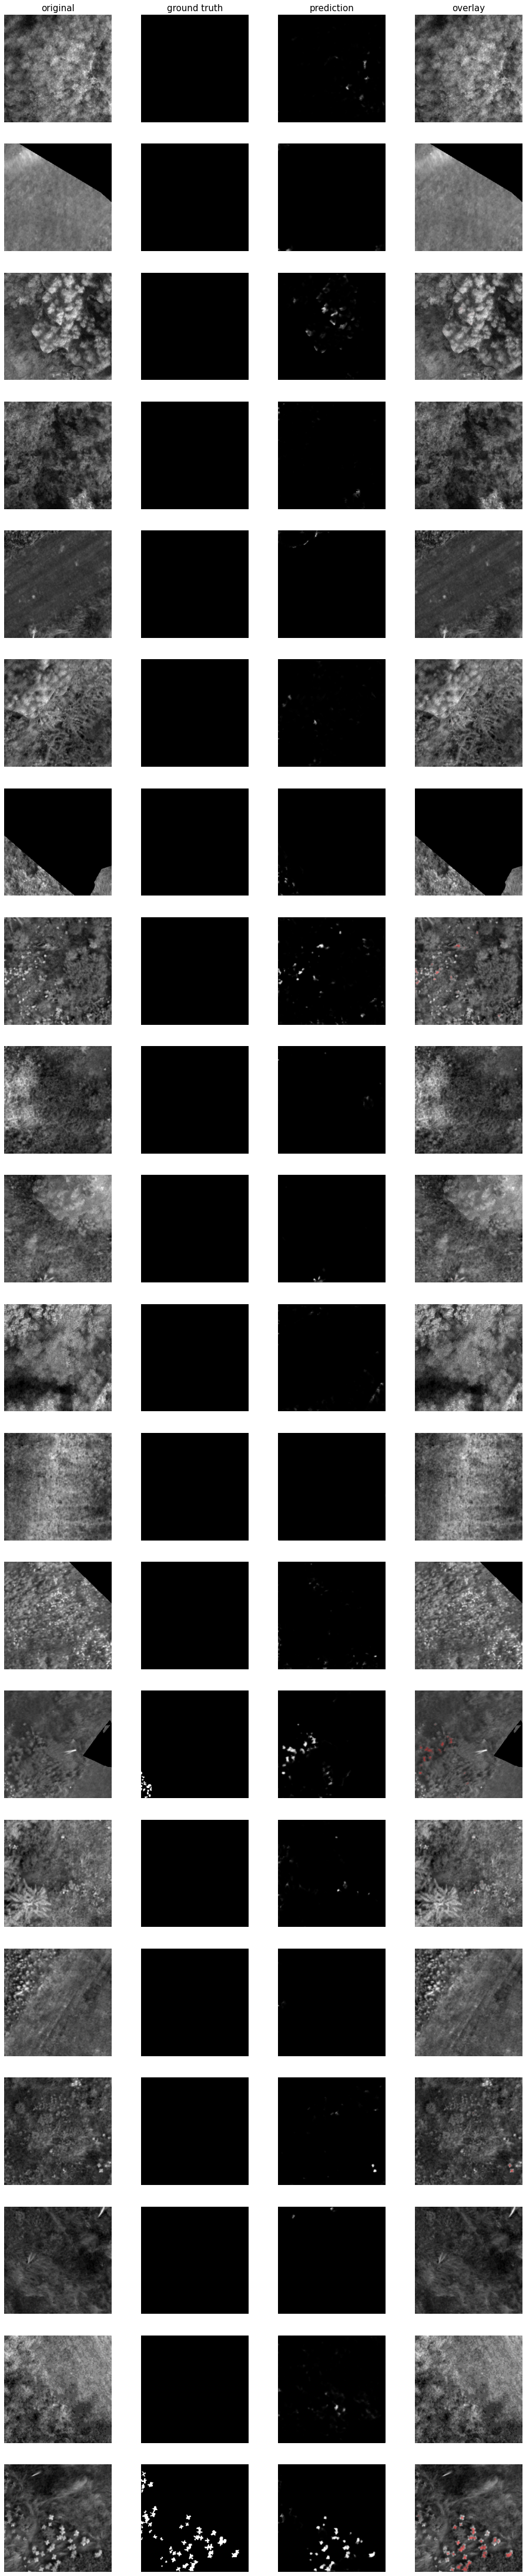

In [29]:
from keras_unet.utils import plot_imgs

# milkweed
plot_imgs(
    org_imgs=train_images_R.reshape(200, N, M, 3)[:,:,:,1], 
    mask_imgs=milk_mask[:, :, :], 
    pred_imgs=Y_pred[:, :, :, 0], 
    nm_img_to_plot=20
  )